In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data/performance_evaluation.csv")

In [3]:
# Drop rows from the rmse and date_true columns that have no value
df.drop(df[pd.isna(df.rmse) == True].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(df[pd.isna(df.date_true) == True].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
print(f"Mean RMSE for all customers: {np.round(np.mean(df['rmse']),2)}")

Mean RMSE for all customers: 4.17


In [5]:
# Change the dates in the dataset to a different format, and turn them into datetime
df["date_delivery"] = df["date_delivery"].replace({'\-':''}, regex=True)
df["date_expected"] = df["date_expected"].replace({'\-':''}, regex=True)
df["date_true"] = df["date_true"].replace({'\-':''}, regex=True)

df["date_delivery"] = pd.to_datetime(df["date_delivery"], format="%Y%m%d")
df["date_expected"] = pd.to_datetime(df["date_expected"], format="%Y%m%d")
df["date_true"] = pd.to_datetime(df["date_true"], format="%Y%m%d")

In [6]:
# Create the true difference and predicted difference columns
df["true_diff"] = df.loc[:,("date_delivery")]-df.loc[:,("date_true")]
df["pred_diff"] = df.loc[:,("date_delivery")]-df.loc[:,("date_expected")]

df["true_diff"] = [np.abs(diff.days) for diff in df["true_diff"]]
df["pred_diff"] = [np.abs(diff.days) for diff in df["pred_diff"]]

In [7]:
# Generate the percent error for each order
percentages = []

for idx, val in enumerate(df["pred_diff"]):
    perc = np.abs(val-df["true_diff"][idx])/df["true_diff"][idx]
    percentages.append(perc)

In [8]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 35.75
Mean percent error: 0.36


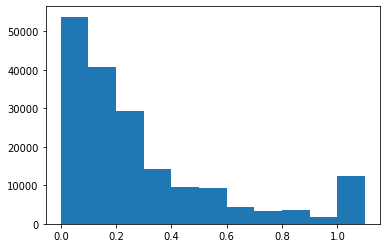

In [9]:
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [10]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 151412
Percentage of orders with a percent error lower than 0.5: 0.83


In [11]:
# Create a new column with the difference between the predicted date and the true delivery date
df["diff"] = df.loc[:,("date_true")]-df.loc[:,("date_expected")]
df["diff"] = [np.abs(diff.days) for diff in df["diff"]]

In [12]:
# Get percentages of orders predicted correctly within a specified number of days
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in df["diff"]]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in df["diff"]]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in df["diff"]]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in df["diff"]]

In [13]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(df['diff']),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(df['diff']),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(df['diff']),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(df['diff']),2)}")

Percentage of orders predicted correctly within 1 day: 0.31
Percentage of orders predicted correctly within 3 days: 0.58
Percentage of orders predicted correctly within 5 days: 0.73
Percentage of orders predicted correctly within 7 days: 0.82


In [14]:
# Create a list of all recipients
recipients = []

for i in df["ship_to_party"]:
    if i not in recipients:
        recipients.append(i)

In [15]:
print(len(recipients))

3278


In [16]:
# Extract the mean RMSE value for each customer and add it to a list
rmse_values = []

for i in recipients:
    test = df[df.ship_to_party == i]
    rmse_values.append(np.mean(test["rmse"]))

In [17]:
print(f"Mean of the mean RMSE per customer: {np.round(np.mean(rmse_values),2)}")
print(f"Smallest mean RMSE: {np.round(np.min(rmse_values),2)}")
print(f"Largest mean RMSE: {np.round(np.max(rmse_values),2)}")

Mean of the mean RMSE per customer: 5.37
Smallest mean RMSE: 0.68
Largest mean RMSE: 61.55


In [18]:
print(f"Mean of the mean RMSE per customer, without the 150 largest values: {np.round(np.average(sorted(rmse_values)[0:-150]),2)}")

Mean of the mean RMSE per customer, without the 150 largest values: 4.7


In [19]:
rmse_values_array = np.asarray(rmse_values)

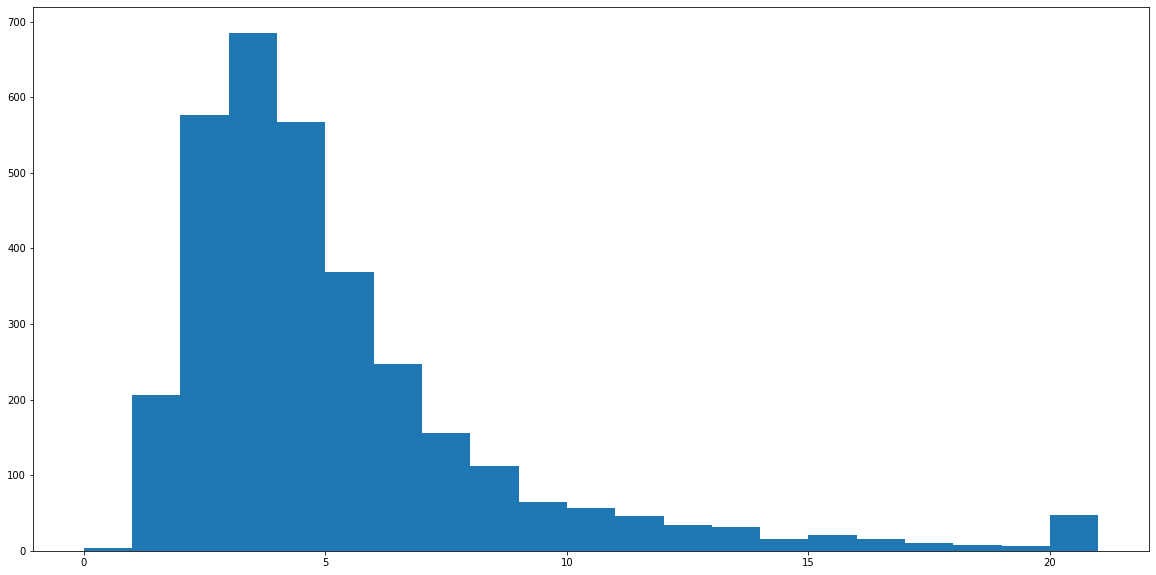

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.hist(rmse_values_array.clip(min=0, max=21), range=[0,21], bins=21)
plt.show()

In [21]:
lower = []

for i in rmse_values:
    if i <= 5:
        lower.append(i)

print(f"Number of customers with an RMSE lower than 5: {len(lower)}")
print(f"Percentage of customer with an RMSE lower than 5: {np.round(len(lower)/len(rmse_values),2)}")

Number of customers with an RMSE lower than 5: 2038
Percentage of customer with an RMSE lower than 5: 0.62


In [22]:
# Create the percent errors for each customer and add it to a list
final_percentages = []

for i in recipients:
    test = df[df.ship_to_party == i]
    percentages = []
    
    for idx, val in enumerate(test["pred_diff"]):
        perc = np.abs(val-df["true_diff"][idx])/df["true_diff"][idx]
        percentages.append(perc)
    
    final_percentages.append(np.mean(percentages))

In [23]:
print(f"Minimum percent error: {np.round(np.min(final_percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(final_percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(final_percentages),2)}")

Minimum percent error: 0.03
Maximum percent error: 2.46
Mean percent error: 0.44


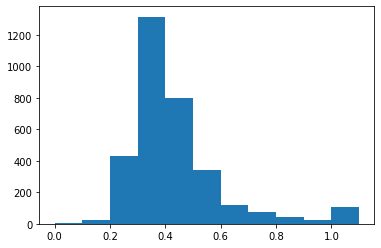

In [24]:
final_percentages = np.asarray(final_percentages)

plt.hist(final_percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [25]:
lower = []

for i in final_percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(final_percentages),2)}")

Number of orders with a percent error lower than 0.5: 2570
Percentage of orders with a percent error lower than 0.5: 0.78


In [26]:
# Get the mean difference for each customer and add them to a list
final_differences = []

for i in recipients:
    test = df[df.ship_to_party == i]
    differences = []
    test.reset_index(drop=True, inplace=True)
    
    for idx, val in enumerate(test["pred_diff"]):
        diff = np.abs(val-test["true_diff"][idx])
        differences.append(diff)

    final_differences.append(np.mean(differences))

In [27]:
# Get percentages of orders predicted correctly within a specified number of days for the per-customer differences
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in final_differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in final_differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in final_differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in final_differences]

In [28]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(final_differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(final_differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(final_differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(final_differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.02
Percentage of orders predicted correctly within 3 days: 0.28
Percentage of orders predicted correctly within 5 days: 0.61
Percentage of orders predicted correctly within 7 days: 0.8
